In [3]:
import csv
import os
import numpy as np
import pandas as pd

In [1]:
num_per_type = 10000
num_types = 9
temp_label_dir = './label'

In [4]:
cnn_list = []
for n in range(1, num_types + 1):
    temp_file_name = 'label_' + str(n) + '.csv'
    temp_label_path = os.path.join(temp_label_dir, temp_file_name)
    reader = pd.read_csv(temp_label_path)
    l = np.array(reader).tolist()
    if len(l) >= num_per_type:
        cnn_list += l[0: num_per_type]
    else:
        cnn_list += l[0: len(l)]

cnn_df = pd.DataFrame(columns=['ID', 'Class'], data=cnn_list)
cnn_df.to_csv('./cnn/label.csv', encoding='utf-8', index=False)


In [4]:
csv_reader = pd.read_csv('./cnn/label.csv')
print(csv_reader.columns)
l = np.array(csv_reader)
l.shape

Index(['ID', 'Class'], dtype='object')


(90, 2)

In [5]:
# from PIL import Image
# import math
# def img_deal(img_dir, id, width=256, height=256):
#     file_dir = os.path.join(img_dir, id + '.png').replace("\\","/")
#     initial_img = Image.open(file_dir)
#     resized_img = initial_img.resize((width, height))
#     resized_img = np.uint8(resized_img)
#     mean = np.mean(resized_img)
#     std = np.std(resized_img)
#     sted_img = (resized_img - mean) / max(std, 1.0 / math.sqrt(width * height))
#     reged_img = np.uint8((nbits - 1) * (sted_img - np.min(sted_img)) / (np.max(sted_img) - np.min(sted_img)))
#     final_img = Image.fromarray(np.uint8(reged_img))
#     return reged_img
#     saved_dir = os.path.join(img_dir, id + '_.png').replace("\\","/")
#     final_img.save(saved_dir)

# for i in range(10):
#     id = l[i][0]
#     img_deal(img_dir, str(id))


In [5]:
from PIL import Image
import math


def img_deal(img, nbits=128, width=256, height=256):
    initial_img = img
    resized_img = initial_img.resize((width, height))
    resized_img = np.uint8(resized_img)
    mean = np.mean(resized_img)
    std = np.std(resized_img)
    sted_img = (resized_img - mean) / max(std, 1.0 / math.sqrt(width * height))
    reged_img = np.uint8((nbits - 1) * (sted_img - np.min(sted_img)
                                        ) / (np.max(sted_img) - np.min(sted_img)))
    return reged_img
    # final_img = Image.fromarray(np.uint8(reged_img))
    # saved_dir = "./cnn/1.png"
    # final_img.save(saved_dir)


In [6]:
data_dir = './dataset/train'
img_dir = './cnn'
nbits = 128
nbits_ = 16
slide_windows = 7

In [12]:
import array
import imageio
import get_glcm
from PIL import Image


def glcm(data_dir="./dataset/train", id="", width=1024, nbits=256, nbits_=16, slide_windows=7, distances=[1, 2, 3, 4], angles=[0, np.pi / 4, np.pi / 2, np.pi * 3 / 4]):
    '''
        Convert binary files into grayscale images and perform image pre-processing 
        followed by feature extraction using GLCM algorithm.

        Args:
            data_dir: The working directory
            id: The binary file's id
            width: The width of the image generated by the B2M algorithm
            nbits: Grayscale value after normalization of the image
            nbits_: Grayscale value of the image after grayscale compression
            slide_windows: Width of sliding window when performing GLCM
            distances: The array of steps used to perform GLCM
            angles: Directional arrays used in performing GLCM

        Returns:
            A 16*16 feature matrix
    '''

    '''
        B2M Algorithm
    '''
    file_dir = os.path.join(data_dir, id + '.bytes').replace("\\", "/")
    f = open(file_dir, 'rb')
    ln = os.path.getsize(file_dir)
    rem = ln % width
    a = array.array("B")
    a.fromfile(f, ln - rem)
    f.close()
    height = int(len(a) / width)
    img = np.reshape(a, (height, width))
    img_ = Image.fromarray(img)
    # img_dir = './cnn/'
    # imageio.imwrite(img_dir + id + '.png', img)

    '''
        Image pre-processing
    '''
    final_img = img_deal(img_, nbits=nbits)

    '''
        GLCM
    '''
    glcm = get_glcm.calcu_glcm(final_img, vmin=0, vmax=nbits-1, nbit=nbits_,
                               slide_window=slide_windows, step=distances, angle=angles)
    value = np.zeros(
        (glcm.shape[2], glcm.shape[3], glcm.shape[4], glcm.shape[5]), dtype=np.float32)
    w = glcm.shape[4]
    for i in range(glcm.shape[2]):
        for j in range(glcm.shape[3]):
            glcm_cut = np.zeros((nbits_, nbits_, w, w), dtype=np.float32)
            glcm_cut = glcm[:, :, i, j, :, :]
            value[i, j, :, :] = get_glcm.calcu_glcm_energy(
                glcm_cut, nbit=nbits_)

    '''
        Pooling & Flatten 
    '''
    final_width = 4
    scale = int(w / final_width)
    value_ = np.zeros(
        (value.shape[0], value.shape[1], final_width, final_width))
    value_ = value.reshape(
        (value.shape[0], value.shape[1], final_width, scale, final_width, scale)).max(5).max(3)
    return value_.reshape((-1, final_width * final_width))


In [15]:
import pandas as pd
csv_reader = pd.read_csv('./cnn/label.csv')
print(csv_reader.columns)
l = np.array(csv_reader).tolist()
new_list = []
for item in l:
    print(item)
    id = item[0]
    en = glcm(data_dir=data_dir, id=id)
    print(en[:, 0, 0, 0])
    break
    

Index(['ID', 'Class'], dtype='object')
['01kcPWA9K2BOxQeS5Rju', 1]
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


In [8]:
import pandas as pd
def batch_processing(data_dir="./dataset/train", label_dir="./cnn/label.csv", save_dir="./cnn/glcm.csv"):
    '''
        Batch image conversion of binary files and extraction of feature values, 
        and finally saved as a CSV file for output.

        Args:
            data_dir: Path to the binary files
            label_dir: Path to the dataset's label
            save_dir: Save path for extracted features

        Returns:
    '''
    csv_reader = pd.read_csv(label_dir)
    print(csv_reader.columns)
    l = np.array(csv_reader).tolist()
    new_list = []
    for item in l:
        print(item)
        id = item[0]
        en = glcm(data_dir=data_dir, id=id).reshape((1, -1)).flatten().tolist()
        str_en = ' '.join([str(x) for x in en])
        item.append(str_en)
        new_list.append(item)
        print(type(item[-1]))
    pd.DataFrame(columns=['ID', 'Class', 'GLCM'], data=new_list).to_csv(save_dir, encoding='utf-8', index=False)

In [14]:
batch_processing()

Index(['ID', 'Class'], dtype='object')
['01kcPWA9K2BOxQeS5Rju', 1]
<class 'str'>
['04EjIdbPV5e1XroFOpiN', 1]
<class 'str'>
['05EeG39MTRrI6VY21DPd', 1]
<class 'str'>
['05rJTUWYAKNegBk2wE8X', 1]
<class 'str'>
['0AnoOZDNbPXIr2MRBSCJ', 1]
<class 'str'>
['0AwWs42SUQ19mI7eDcTC', 1]
<class 'str'>
['0cH8YeO15ZywEhPrJvmj', 1]
<class 'str'>
['0DNVFKwYlcjO7bTfJ5p1', 1]
<class 'str'>
['0DqUX5rkg3IbMY6BLGCE', 1]
<class 'str'>
['0eaNKwluUmkYdIvZ923c', 1]
<class 'str'>
['0fHVZKeTE6iRb1PIQ4au', 1]
<class 'str'>
['0G4hwobLuAzvl1PWYfmd', 1]
<class 'str'>
['0gkj92oIleU4SYiCWpaM', 1]
<class 'str'>
['0H63jydvIahOVqgx5Kfo', 1]
<class 'str'>
['0Hrfce4X5YGESJPjl9uL', 1]
<class 'str'>
['0I4ZVvngsAatm8fzD3pk', 1]
<class 'str'>
['0iBaz3krsQ8HuA7cGDSt', 1]
<class 'str'>
['0iS3pwlgJco8XORD4TLq', 1]
<class 'str'>
['0jkmvR43UQ9yKxqXei61', 1]
<class 'str'>
['0KigmP9TLwJXNGz26tfO', 1]
<class 'str'>
['0l6fhCty3aSLDOgAjYQi', 1]
<class 'str'>
['0MOorvEIRmZGhqQdc3TA', 1]
<class 'str'>
['0NEsQlDGnUMg3Bew7R1A', 1]
<class 's

In [11]:
def get_feature_data(llist):
    res = []
    for ll in llist:
        list_str = ll[2].split(" ")
        list = [int(float(i)) for i in list_str]
        res.append(list)
    return np.array(res)

In [12]:
import pandas as pd
import numpy as np
reader = pd.read_csv('./cnn/glcm.csv')
llist = np.array(reader)
res = get_feature_data(llist)
print(res.shape)

ValueError: cannot convert float NaN to integer

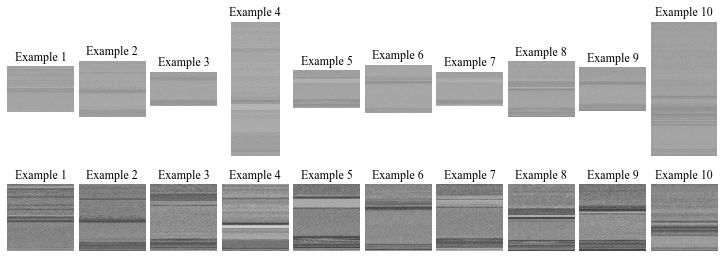

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import math

plt.figure(figsize=(10, 4))
font = {'family': 'Times New Roman',
        'weight': 'normal',
        'size': 12,
        }

for i in range(10):
    id = l[i][0]
    file_dir_1 = os.path.join(img_dir, str(id) + '.png').replace("\\", "/")
    initial_img = Image.open(file_dir_1)
    plt.subplot(2, 10, i+1)
    plt.tick_params(labelbottom=False, labelleft=False)
    plt.axis('off')
    plt.imshow(initial_img, cmap='gray')
    plt.title(f'Example {i+1}', font)
imgs = []
for i in range(10):
    id = l[i][0]
    file_dir_2 = os.path.join(img_dir, str(id) + '_.png').replace("\\", "/")
    initial_img = Image.open(file_dir_2)
    plt.subplot(2, 10, i+11)
    plt.tick_params(labelbottom=False, labelleft=False)
    plt.axis('off')
    plt.imshow(initial_img, cmap='gray')
    plt.title(f'Example {i+1}', font)

plt.tight_layout(pad=0.5)
plt.show()
